In [1]:
# Standard Libraries
import os
import io
import math
import time
import random
import tempfile
import warnings
from multiprocessing import Manager
from typing import Optional

# Third-party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import torch
import torch.nn as nn
import torchio as tio
from torch.utils.data import DataLoader, Dataset, random_split
from torch.cuda.amp import GradScaler, autocast

# MONAI Libraries
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.transforms import (
    AddChanneld, 
    CenterSpatialCropd, 
    Compose, 
    Lambdad, 
    LoadImaged, 
    Resized, 
    ScaleIntensityd
)
from monai.utils import set_determinism

# Custom Libraries
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
from dataloader import Train ,Eval 

# Configuration
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")
warnings.filterwarnings('ignore')


JUPYTER_ALLOW_INSECURE_WRITES=True

/home1/akrami/.conda/envs/working_monai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-10-07 11:30:17,531 - A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
2023-10-07 11:30:20,716 - Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: hale-akrami (usc_akrami). Use `wandb login --relogin` to force relogin


In [2]:
# Initialize Configuration
config = {
    'batch_size': 4,
    'imgDimResize': (160, 192, 160),
    'imgDimPad': (208, 256, 208),
    'spatialDims': '3D',
    'unisotropic_sampling': True,
    'perc_low': 1,
    'perc_high': 99,
    'rescaleFactor': 2,
    'base_path': '/scratch1/akrami/Latest_Data/Data',
}

# Seed and Device Configuration
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CUDA and CUDNN Configuration
# Uncomment the following line to specify CUDA_VISIBLE_DEVICES
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# SimpleITK Configuration
# Set the default number of threads and global behavior for SimpleITK
sitk.ProcessObject.SetGlobalDefaultThreader("Platform")



True

In [3]:

csvpath_trains=['./combined.csv']
pathBase = '/scratch1/akrami/Data_train'
csvpath_val = '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/IXI_val_fold0.csv'
csvpath_test = '/project/ajoshi_27/akrami/patched-Diffusion-Models-UAD/Data/splits/Brats21_sub_test.csv'
var_csv = {}
states = ['train','val','test']

df_list = []

# Loop through each CSV file path and read it into a DataFrame
for csvpath in csvpath_trains:
    df = pd.read_csv(csvpath)
    df_list.append(df)

# dfffff=  pd.concat(df_list, ignore_index=True)
# dfffff.to_csv("./combined.csv", index=False)
var_csv['train'] =pd.concat(df_list, ignore_index=True)
var_csv['val'] = pd.read_csv(csvpath_val)
var_csv['test'] = pd.read_csv(csvpath_test)
# if cfg.mode == 't2':
#     keep_t2 = pd.read_csv(cfg.path.IXI.keep_t2) # only keep t2 images that have a t1 counterpart

for state in states:
    var_csv[state]['settype'] = state
    var_csv[state]['norm_path'] = pathBase  + var_csv[state]['norm_path']
    var_csv[state]['img_path'] = pathBase  + var_csv[state]['img_path']
    var_csv[state]['mask_path'] = pathBase  + var_csv[state]['mask_path']
    if state != 'test':
        var_csv[state]['seg_path'] = None
    else:
        var_csv[state]['seg_path'] = pathBase  + var_csv[state]['seg_path']

    # if cfg.mode == 't2': 
    #     var_csv[state] =var_csv[state][var_csv[state].img_name.isin(keep_t2['0'].str.replace('t2','t1'))]
    #     var_csv[state]['img_path'] = var_csv[state]['img_path'].str.replace('t1','t2')
    
    
data_train = Train(var_csv['train'],config) 
data_val = Train(var_csv['val'],config)                
data_test = Eval(var_csv['test'],config)



# #data_train = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_train_fold0.csv', converters={'img_path': pd.eval}), config)
train_loader = DataLoader(data_train, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_val = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/IXI_val_fold0.csv', converters={'img_path': pd.eval}), config)
val_loader = DataLoader(data_val, batch_size=config.get('batch_size', 1),shuffle=True,num_workers=8)

#data_test = Train(pd.read_csv('/project/ajoshi_27/akrami/monai3D/GenerativeModels/data/split/Brats21_test.csv', converters={'img_path': pd.eval}), config)
test_loader = DataLoader(data_test, batch_size=config.get('batch_size', 1),shuffle=False,num_workers=8)


In [4]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=[32, 64, 128, 128],
    attention_levels=[False, False, False,True],
    num_head_channels=[0, 0, 0,32],
    num_res_blocks=2,
)
model.to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

Using 2 GPUs!


In [6]:
# specify your model filename
#model_filename = '/scratch1/akrami/models/3Ddiffusion/half/model_epoch984.pt'
model_filename ='/project/ajoshi_27/akrami/3D_lesion_DF/models/half/model_epoch549.pt'
# load state_dict into the model
model.load_state_dict(torch.load(model_filename))

# if you need to set the model in evaluation mode
model.eval()

DataParallel(
  (module): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            )
       

## Sampling Brain Image

In order to sample the brain images, we need to pass the model an image containing just noise and use it to remove the noise of the image iteratively. For that, we will use the `.sample()` function of the `inferer`.

In [8]:
sub_test = next(iter(test_loader))
print(sub_test.keys())
print(sub_test['age'])


dict_keys(['vol', 'peak', 'seg', 'age', 'ID', 'path', 'mask'])
tensor([    nan, 85.9420, 57.0000,     nan], dtype=torch.float64)


In [9]:

# Expand the dimensions of sub_test['peak'] to make it [1, 1, 1, 1, 4]
peak_expanded = (sub_test['peak'].unsqueeze(1).unsqueeze(2).unsqueeze(3).unsqueeze(4)).long()
# Move both tensors to the device
image_array = sub_test['vol']['data'].to(device)
peak_expanded = peak_expanded.to(device)
image_array = (image_array / peak_expanded)
middle_slice_idx = image_array.size(-1) // 2

In [10]:

noise = torch.randn_like(image_array)[0:1,:,:,:]
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [02:55<00:00,  5.71it/s]


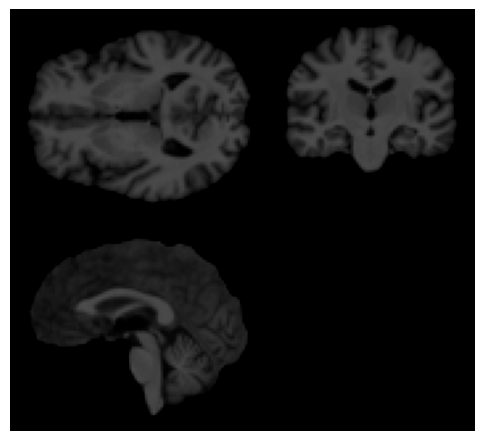

In [12]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.flipud(image[0, 0, :, 48, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 40, :, :].cpu().T), np.zeros((80, 80))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=2, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

100%|██████████| 1000/1000 [02:16<00:00,  7.30it/s]


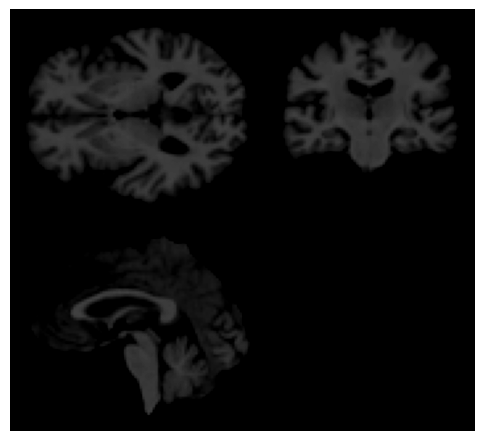

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


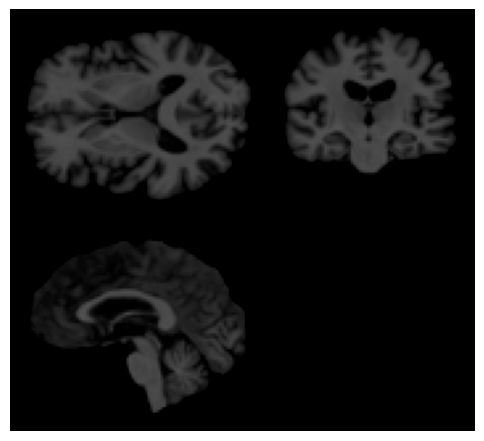

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


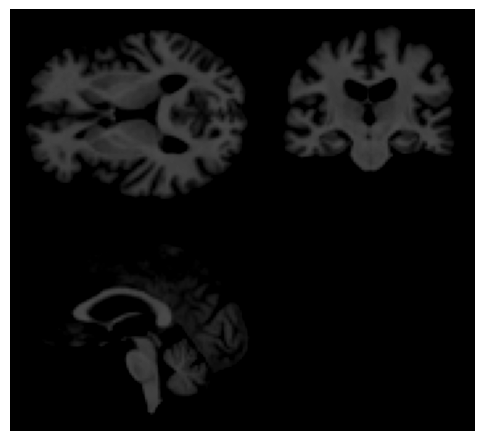

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


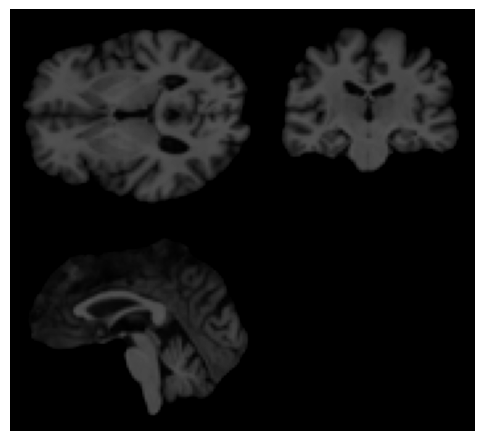

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


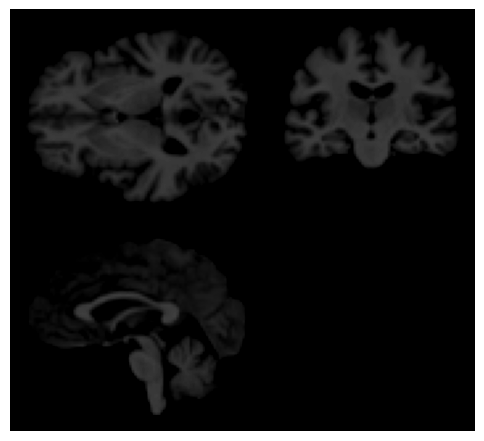

100%|██████████| 1000/1000 [02:17<00:00,  7.30it/s]


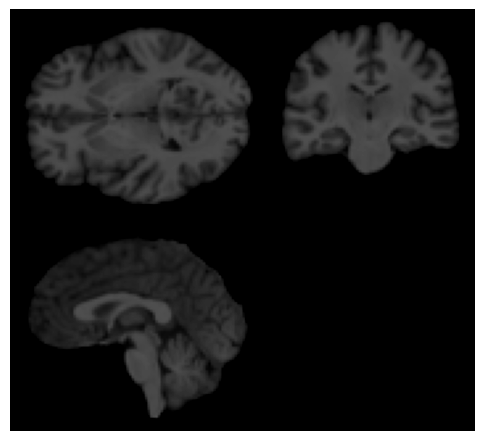

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


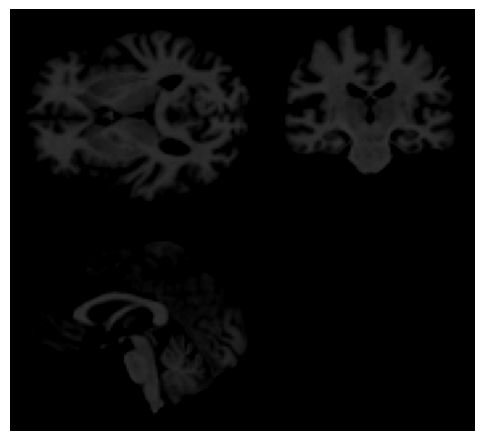

100%|██████████| 1000/1000 [02:17<00:00,  7.30it/s]


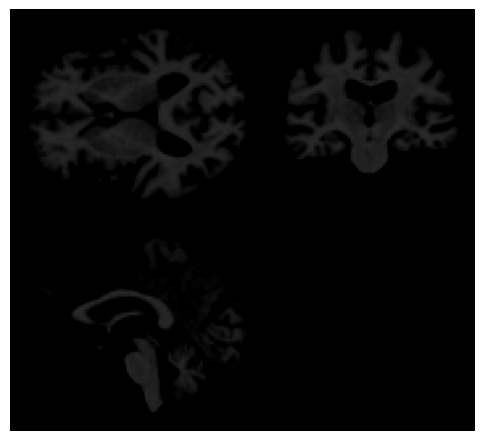

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


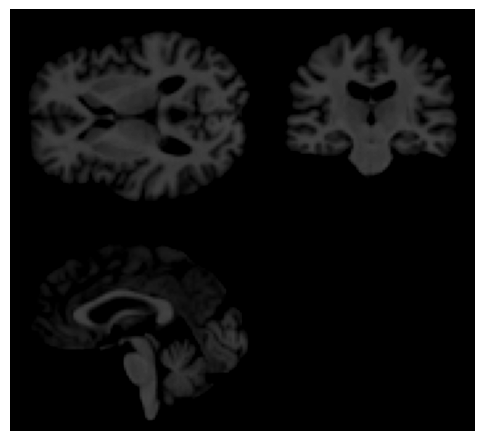

100%|██████████| 1000/1000 [02:16<00:00,  7.30it/s]


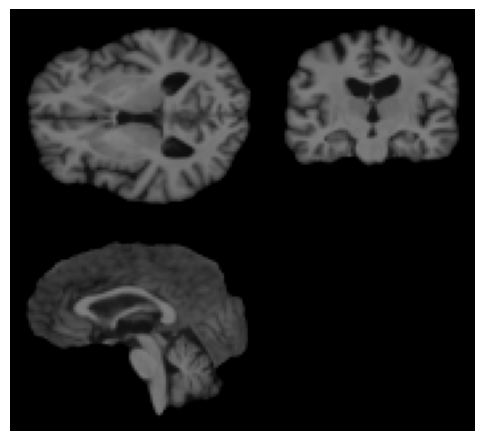

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


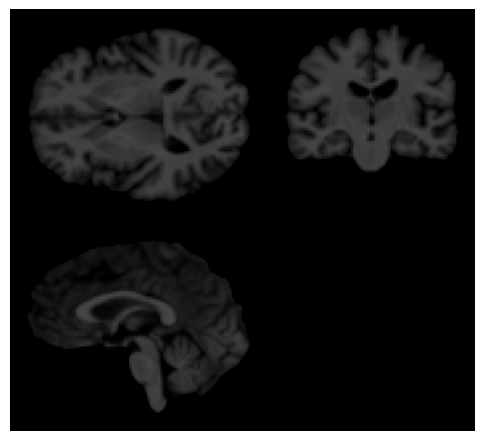

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


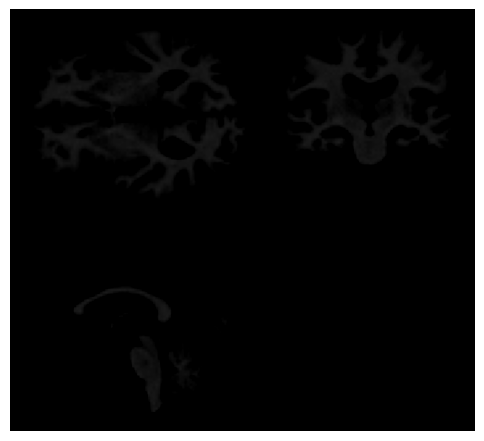

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


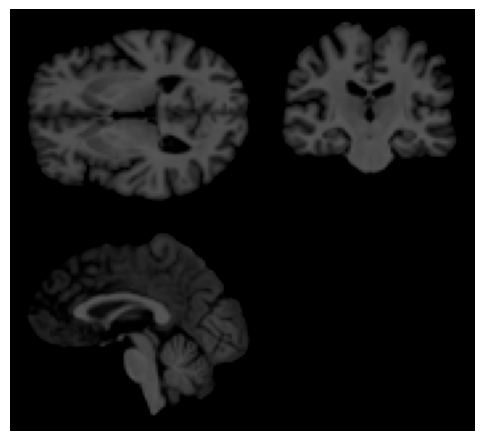

100%|██████████| 1000/1000 [02:16<00:00,  7.30it/s]


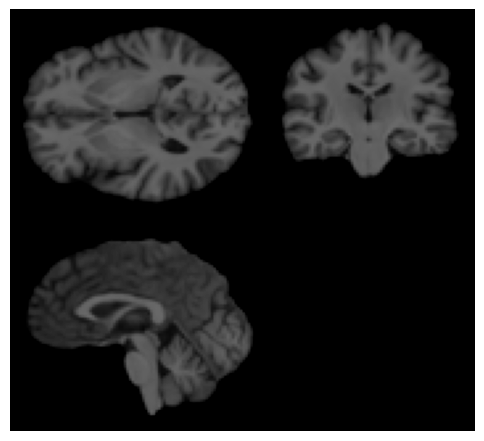

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


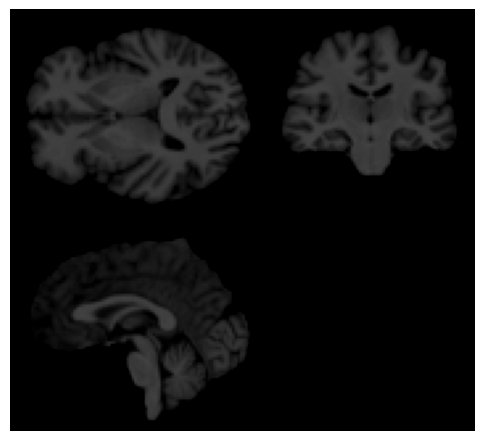

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


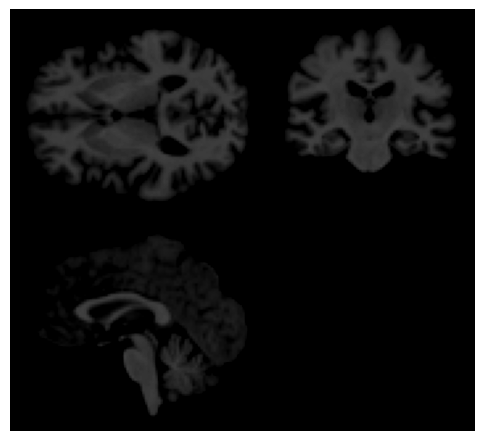

100%|██████████| 1000/1000 [02:16<00:00,  7.30it/s]


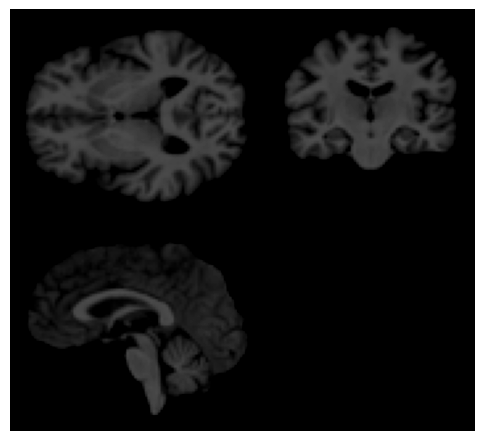

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


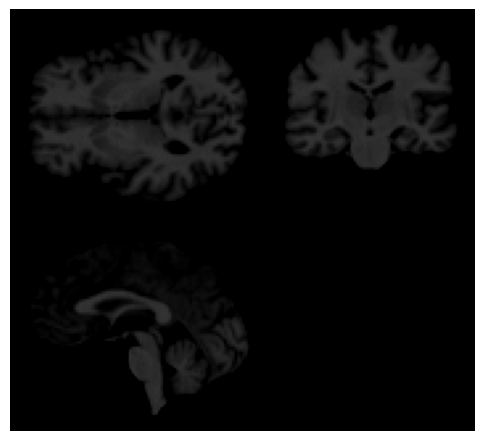

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


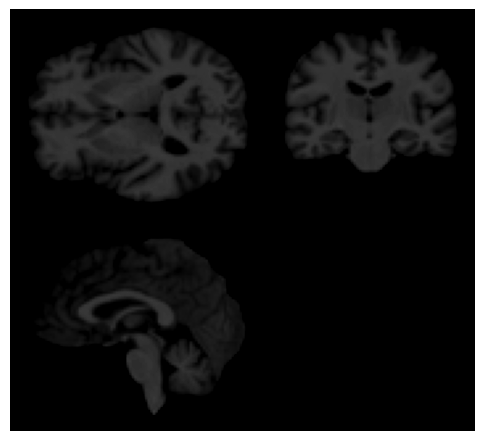

100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s]


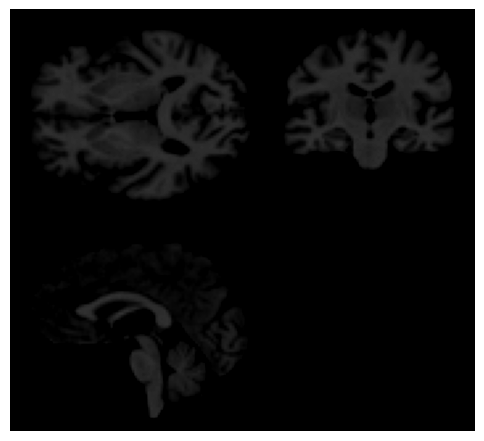

In [14]:
num_sample = 20
import nibabel as nib
for i in range (num_sample):
    noise = torch.randn_like(image_array)[0:1,:,:,:]
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)
    image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
    plt.style.use("default")
    plotting_image_0 = np.concatenate([image[0, 0, :, :, 40].cpu(), np.flipud(image[0, 0, :, 48, :].cpu().T)], axis=1)
    plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 40, :, :].cpu().T), np.zeros((80, 80))], axis=1)
    plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=2, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()

    image_data = image.squeeze().cpu().numpy()
    
    # Change datatype to float64 (optional, only if your data is not complex)
    image_data = image_data.astype(np.float64)
    nii_img = nib.Nifti1Image(image_data, np.eye(4))
    
    # Save the image
    nib.save(nii_img, f"test_image_{i}.nii")

    

Shape of the NIfTI file 'test_image_bio.nii': (160, 192, 160)


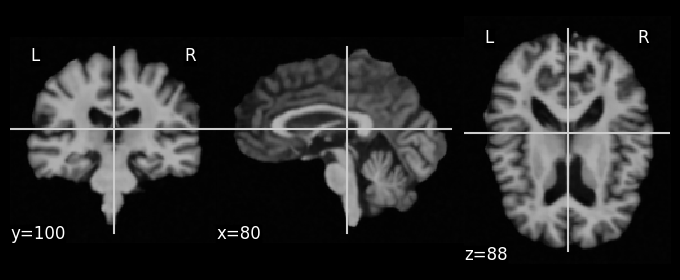

In [16]:
from nilearn.plotting import plot_anat
import nibabel as nib

def print_nifti_shape(file_path):
    try:
        # Load the NIfTI file
        nifti_img = nib.load(file_path)

        # Get the shape of the NIfTI data array
        data_shape = nifti_img.get_fdata().shape

        # Print the shape
        print(f"Shape of the NIfTI file '{file_path}': {data_shape}")
    except Exception as e:
        print(f"Error: {e}")

plot_anat("test_image_bio.nii")
# Replace 'your_nifti_file.nii' with the actual path to your NIfTI file
nifti_file_path = "test_image_bio.nii"
print_nifti_shape(nifti_file_path)


In [28]:
noise =torch.randn_like(image_array)
#for i in range(1000):
#noisy_img = scheduler.add_noise(original_samples=noisy_img, noise=noise, timesteps=torch.tensor(i))
noisy_img_v2 = scheduler.add_noise(original_samples=image_array, noise=noise, timesteps=torch.tensor(500))

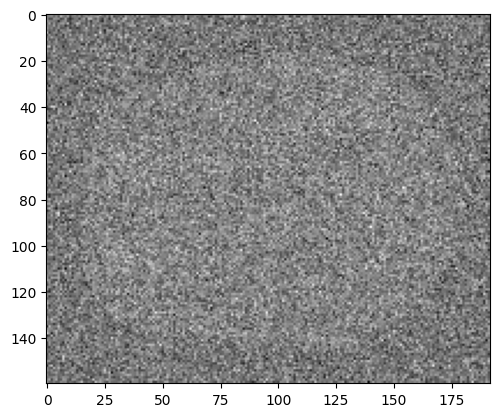

In [29]:

plt.imshow(noisy_img_v2[0][0][:,:,80].squeeze().cpu().numpy(), cmap='gray')

In [30]:
# scheduler.set_timesteps(num_inference_steps=90)
# with autocast(enabled=True):
#     decoded = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

# scheduler.set_timesteps(num_inference_steps=1000)
# image_xx = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)
# plt.rcParams['figure.figsize'] = (5, 5)
# plt.style.use("default")
# plt.imshow(image_xx[0][0][:,:,40].detach().cpu(), vmin=0, vmax=1, cmap="gray")
# plt.tight_layout()
# plt.axis("off")
# plt.show()

#noise = torch.randn((1, 1, 80, 96, 80))
noise = noisy_img_v2[0:1,:,:,:,:].to(device)
scheduler.set_timesteps(num_inference_steps=1000)
image_xx = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


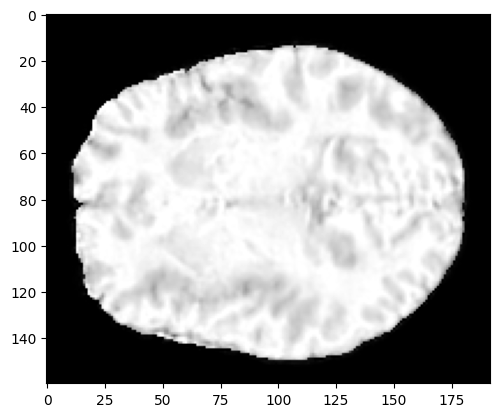

In [35]:


# Now when displaying any image:
#plt.imshow(diff_image[0][0][:,:,80].squeeze().cpu().numpy(), cmap='gray', vmin=global_vmin, vmax=global_vmax)
plt.imshow(image_xx[0][0][:,:,80].squeeze().cpu().numpy(),vmin=0, vmax=1, cmap='gray')

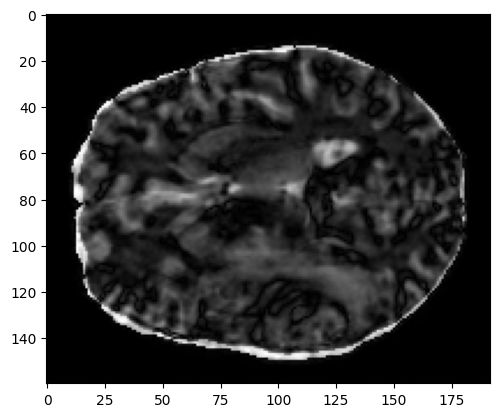

In [36]:
diff_image = torch.abs(image_xx.to(device)-image_array[0:1,:,:,:,:].to(device))
plt.imshow(diff_image[0][0][:,:,80].squeeze().cpu().numpy(),vmin=0, vmax=1, cmap='gray')

In [37]:
import nibabel as nib
image_data = image_xx.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_brats_recon_image_2.nii')

In [38]:
import nibabel as nib
image_data = image_array.squeeze().cpu().numpy()

# Change datatype to float64 (optional, only if your data is not complex)
image_data = image_data.astype(np.float64)
nii_img = nib.Nifti1Image(image_data, np.eye(4))

# Save the image
nib.save(nii_img, 'test_brats_image_2.nii')

### Sampling with Denoising Diffusion Implicit Model Scheduler

Recent papers have proposed different ways to improve the sampling speed by using fewer steps in the denoising process. In this example, we are using a `DDIMScheduler` (from [Song et al. "Denoising Diffusion Implicit Models"](https://arxiv.org/abs/2010.02502)) to reduce the original number of steps from 1000 to 250.

In [ ]:
scheduler_ddim = DDIMScheduler(
    num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195, clip_sample=False
)

scheduler_ddim.set_timesteps(num_inference_steps=250)

model.eval()
noise = torch.randn((1, 1, 32, 40, 32))
noise = noise.to(device)

image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler_ddim)

In [ ]:
plt.style.use("default")
plotting_image_0 = np.concatenate([image[0, 0, :, :, 15].cpu(), np.flipud(image[0, 0, :, 20, :].cpu().T)], axis=1)
plotting_image_1 = np.concatenate([np.flipud(image[0, 0, 15, :, :].cpu().T), np.zeros((32, 32))], axis=1)
plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()